# Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Functions

In [7]:
def spot_check_models(X,y):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
    X: Pd.Dataframe
    y: Pd.Series

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }
    
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X,y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

def check_class_imbalance(df):
  
  y = df.values[:,-1]
  counter = Counter(y)
  
  for k,v in counter.items():
    per = v/len(y) * 100
    print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v, per))

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/test/Documents/Software-projects/Python Projects/Machine Learning Projects/Mushroon-Classification-Accuracy/mushroom_cleaned.csv", nrows=10000)
df

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
9995,198,6,0,7,0.150776,195,11,0.888450,1
9996,218,6,0,10,0.755582,218,6,0.943195,1
9997,221,6,0,10,0.568570,212,11,0.943195,1
9998,180,6,0,10,0.385536,179,6,0.888450,1


# Check for Nulls and Duplicates

In [3]:
print(f"Sum of the nulls: {df.isna().sum()}")
print(f"Number of duplicates: {df.duplicated().sum()}")

Sum of the nulls: cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64
Number of duplicates: 1


In [4]:
df.drop_duplicates(inplace=True)

# Check for class imbalance

In [8]:
check_class_imbalance(df)

Class=1, Count=5057, Percentage=50.575%
Class=0, Count=4942, Percentage=49.425%


# Visuals

<Axes: >

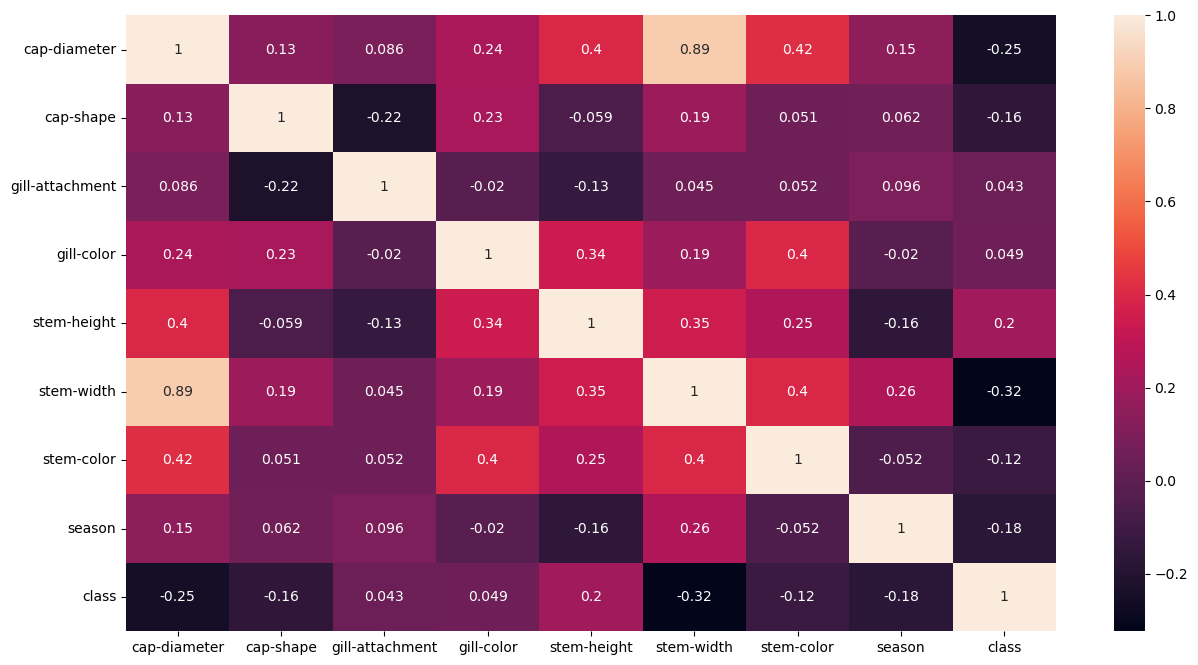

In [9]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations,annot=True)

<Axes: xlabel='cap-diameter', ylabel='stem-width'>

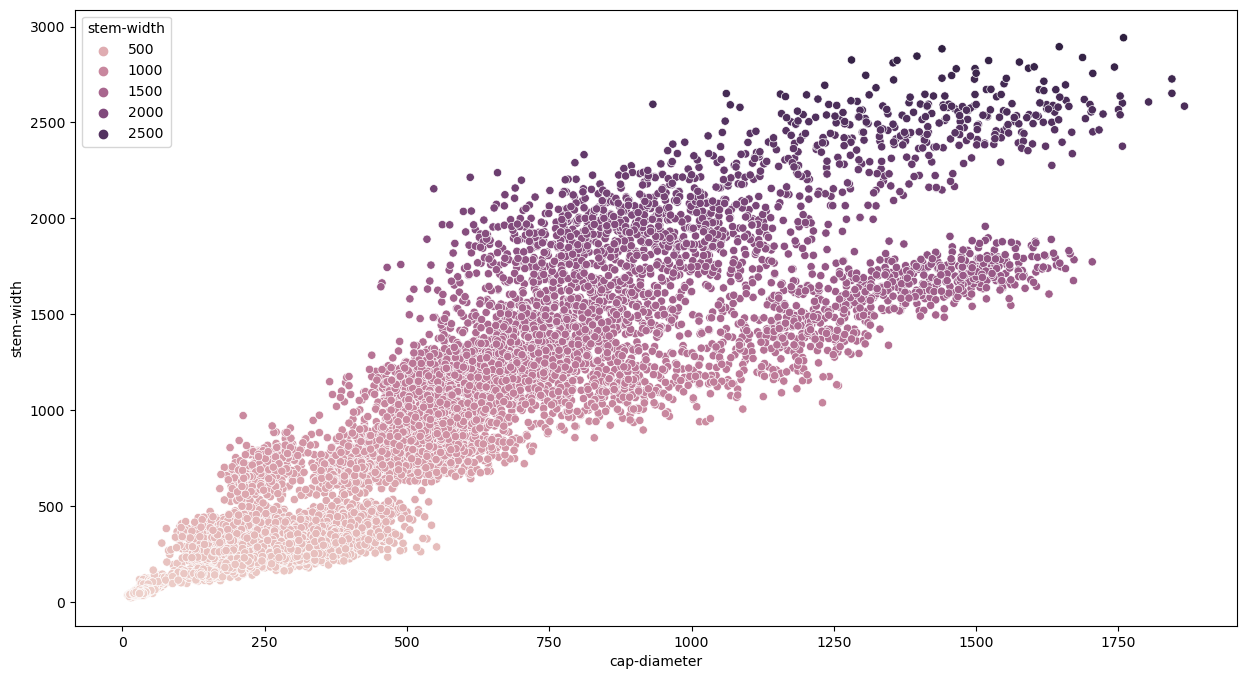

In [10]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="cap-diameter",y="stem-width", hue="stem-width")

# Split up feature variables

In [11]:
X,y = df.drop("class",axis=1), df["class"]

# Baseline Model Evaluation

In [12]:
model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X,y, model)
print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.499 (0.013)


# Spot check Algorithms

In [13]:
spot_check_models(X, y)